In [126]:

import numpy as np
import cv2
from tensorflow.keras.datasets import cifar10
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch

# # Load data
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

from tensorflow.keras.utils import image_dataset_from_directory

# Load ImageNette dataset
train_dir = "/home/redix/Desktop/prml/data/imagenette2-320/train"
val_dir = "/home/redix/Desktop/prml/data/imagenette2-320/val"

# Define parameters
img_size = (128, 128)  # Resize to match CIFAR-10's 32x32 dimensions
batch_size = 32  # Adjust as needed

# Load dataset
train_ds = image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds = image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)

# Convert datasets to numpy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(val_ds)

# Ensure shapes match CIFAR-10 format
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

# Normalize images to [0, 1] range like CIFAR-10
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

# Config
N_CLUSTERS, N_SAMPLES = 50, 2000
np.random.seed(26)

def extract_features(img):
    # Convert to grayscale
    img = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
    
    # Extract HOG features
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    
    # Extract SIFT features
    try:
        sift = cv2.SIFT_create(nfeatures=50)
        _, desc = sift.detectAndCompute(gray, None)
        desc_feat = desc.mean(axis=0) if desc is not None and desc.size > 0 else np.zeros(128)
    except:
        desc_feat = np.zeros(128)
        
    if not hasattr(extract_features, "model"):
        extract_features.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        extract_features.model = nn.Sequential(*list(extract_features.model.children())[:-1])
        extract_features.model.eval()
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_resized = transform(img).unsqueeze(0) 
    with torch.no_grad():
        effnet_feat = extract_features.model(img_resized).flatten().numpy()
    
    return np.hstack([hog_feat, desc_feat, effnet_feat])

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


In [127]:

print("Building vocabulary...")
indices = np.random.choice(len(x_train), N_SAMPLES)
features = np.array([extract_features(x_train[i]) for i in indices])
print("Extracted features from training set.")
pca = PCA(n_components=50).fit(features)
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(pca.transform(features))


Building vocabulary...
Extracted features from training set.


In [128]:
print("Inertia:", kmeans.inertia_)

Inertia: 7513731.014028311


In [129]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
score = silhouette_score(pca.transform(features), labels)
print("Silhouette Score:", score)

Silhouette Score: 0.0559917263889916


In [130]:

# Create histogram for an image
def get_hist(img):
    feat_pca = pca.transform(extract_features(img).reshape(1, -1))
    pred = kmeans.predict(feat_pca)
    hist = np.bincount(pred, minlength=N_CLUSTERS)
    return hist / max(hist.sum(), 1e-10)

# Process test set
print("Processing test set...")
test_hists = np.array([get_hist(img) for img in x_test])

# Retrieve similar images
def retrieve(q_img, q_idx=None, n=5):
    q_hist = get_hist(q_img)
    # Chi-square distance
    dist = 0.5 * np.sum(((q_hist - test_hists) ** 2) / (q_hist + test_hists + 1e-10), axis=1)
    idx = np.argsort(dist)
    if q_idx is not None:
        idx = idx[idx != q_idx]
    return idx[:n]




Processing test set...


In [131]:
# Evaluate retrieval performance
def evaluate(queries=100, top_k=5):
    mAP = []
    for idx in np.random.choice(len(x_test), queries):
        ret_idx = retrieve(x_test[idx], idx, top_k)
        relevant = (y_test == y_test[idx])
        ap = average_precision_score(relevant[ret_idx], np.arange(len(ret_idx), 0, -1)) if np.sum(relevant[ret_idx]) > 0 else 0
        mAP.append(ap)
    return np.mean(mAP)

# Run evaluation
print(f"Mean Average Precision: {evaluate():.4f}")

Mean Average Precision: 0.2755


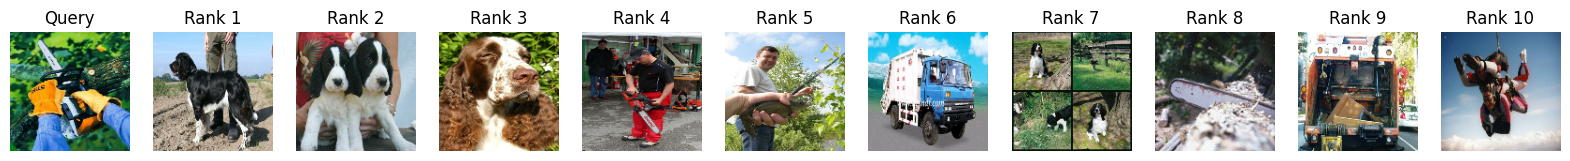

In [134]:
import numpy as np
import matplotlib.pyplot as plt

def plot_retrieval(query_idx, top_k=5):
    ret_idx = retrieve(x_train[query_idx], query_idx, top_k)

    plt.figure(figsize=(20, 10))

    # Plot the query image
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(x_train[query_idx], cmap='gray')
    plt.title("Query")
    plt.axis('off')

    # Plot retrieved images
    for i, idx in enumerate(ret_idx):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(x_test[idx], cmap='gray')
        plt.title(f"Rank {i+1}")
        plt.axis('off')

    plt.show()

# Example usage
query_idx = np.random.randint(len(x_train))
plot_retrieval(query_idx, top_k=10)


In [ ]:
# from sklearn.mixture import GaussianMixture

# print("Building vocabulary...")
# indices = np.random.choice(len(x_train), N_SAMPLES)
# features = np.array([extract_features(x_train[i]) for i in indices])
# print("Extracted features from training set.")
# pca = PCA(n_components=50).fit(features)
# gmm = GaussianMixture(n_components=N_CLUSTERS).fit(pca.transform(features))


Building vocabulary...
Extracted features from training set.


In [54]:
# gmm_labels = gmm.predict(pca.transform(features))
# silhouette_gmm = silhouette_score(pca.transform(features), gmm_labels)
# print("Silhouette Score (GMM):", silhouette_gmm)

In [55]:
import optuna
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 10, 100, step=5) 
    n_components = trial.suggest_int("n_components", 10, 256, step=10)  
    clustering_method = trial.suggest_categorical("clustering_method", ["kmeans"])

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    # Clustering
    if clustering_method == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=32, n_init=10)
        labels = model.fit_predict(reduced_features)
    else:  # GMM
        model = GaussianMixture(n_components=n_clusters, random_state=32)
        labels = model.fit_predict(reduced_features)

    # Compute Silhouette Score
    score = silhouette_score(reduced_features, labels)
    return score  # Higher is better

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best Parameters
print("Best Parameters:", study.best_params)
print("Best Silhouette Score:", study.best_value)

[I 2025-03-27 23:10:38,259] A new study created in memory with name: no-name-e3112996-bfd4-4a5a-96f6-51aa45f85668
/home/redix/Desktop/prml/.venv/lib/python3.10/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [10, 256] and step=10, but the range is not divisible by `step`. It will be replaced by [10, 250].
  warnings.warn(
[I 2025-03-27 23:10:44,193] Trial 0 finished with value: 0.08271460980176926 and parameters: {'n_clusters': 95, 'n_components': 10, 'clustering_method': 'kmeans'}. Best is trial 0 with value: 0.08271460980176926.
/home/redix/Desktop/prml/.venv/lib/python3.10/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [10, 256] and step=10, but the range is not divisible by `step`. It will be replaced by [10, 250].
  warnings.warn(
[I 2025-03-27 23:10:49,635] Trial 1 finished with value: 0.09108420461416245 and parameters: {'n_clusters': 40, 'n_components': 10, 'clustering_method': 'kmeans'}. Best is

KeyboardInterrupt: 

NameError: name 'l' is not defined